- importing libiaries 
- set API key
- define variables 

In [14]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
from datetime import date, timedelta, datetime
import seaborn as sns
#import cryptocompare as cc
import requests
#import IPython
import yaml
import json

yaml_file = open('api_key/api_config_cc.yml', 'r')
p = yaml.load(yaml_file, Loader=yaml.FullLoader)
api_key = p['api_key']


data_limit = 2000

btc = 'BTC'
eth = 'ETH'



define two functions 
- api request 
- data preparation 

In [15]:
def api_request(url):
    headers = {'authorization': 'Apikey ' + api_key,}
    session = requests.Session()
    session.headers.update(headers)

    response = session.get(url)

    #print('Response Status Code:', response.status_code)

    blockchain_data_dict = json.loads(response.text)

    #print('Response Content:', response.text)
    #print('blockchain_data_dict:', blockchain_data_dict)


    df = pd.DataFrame.from_dict(blockchain_data_dict.get('Data').get('Data'), orient='columns', dtype=None, columns=None)

    return(df)
def prepare_pricedata(df):
    df['date'] = pd.to_datetime(df['time'], unit='s')
    df.drop(columns=['time', 'conversionType', 'conversionSymbol'], inplace=True)
    return df

base_url = 'https://min-api.cryptocompare.com/data/v2/histoday?fsym='
df_btc = api_request(f'{base_url}{btc}&tsym=USD&limit={data_limit}')
btc_price_df = prepare_pricedata(df_btc)
print(btc_price_df.head(3))
df_eth = api_request(f'{base_url}{eth}&tsym=USD&limit={data_limit}')
eth_price_df = prepare_pricedata(df_eth)
print(eth_price_df.head(3))





       high       low      open  volumefrom      volumeto     close       date
0  11175.23  10715.55  10861.47    86825.51  9.504742e+08  10912.73 2017-12-02
1  11851.09  10578.43  10912.72   122125.70  1.380012e+09  11246.21 2017-12-03
2  11624.63  10917.81  11244.20    93173.90  1.057859e+09  11623.91 2017-12-04
     high     low    open  volumefrom      volumeto   close       date
0  471.39  449.69  461.58   464500.81  2.147326e+08  457.96 2017-12-02
1  481.56  445.57  457.96   509415.89  2.379187e+08  462.81 2017-12-03
2  472.16  446.64  462.92   411969.17  1.898777e+08  466.93 2017-12-04


on-chain API request

In [16]:
base_url = 'https://min-api.cryptocompare.com/data/blockchain/histo/day?fsym='
onchain_btc_df = api_request(f'{base_url}{btc}&limit={data_limit}')
onchain_eth_df = api_request(f'{base_url}{eth}&limit={data_limit}')
onchain_btc_df.head(3)



,id,symbol,time,zero_balance_addresses_all_time,unique_addresses_all_time,new_addresses,active_addresses,transaction_count,transaction_count_all_time,large_transaction_count,average_transaction_value,block_height,hashrate,difficulty,block_time,block_size,current_supply
0,1182,BTC,1512172800,315512049,339109926,488452,965635,326354,277392487,31381,6.565847,497275,1.080032e+07,1.347001e+12,535.662500,1036298,1.671594e+07
1,1182,BTC,1512259200,315974898,339649758,539832,1032301,353044,277745531,23273,5.298105,497451,1.177726e+07,1.347001e+12,491.228571,1047375,1.671814e+07
2,1182,BTC,1512345600,316486668,340271118,621360,1154127,400686,278146217,40778,6.522200,497632,1.207401e+07,1.347001e+12,479.155556,1068300,1.672040e+07


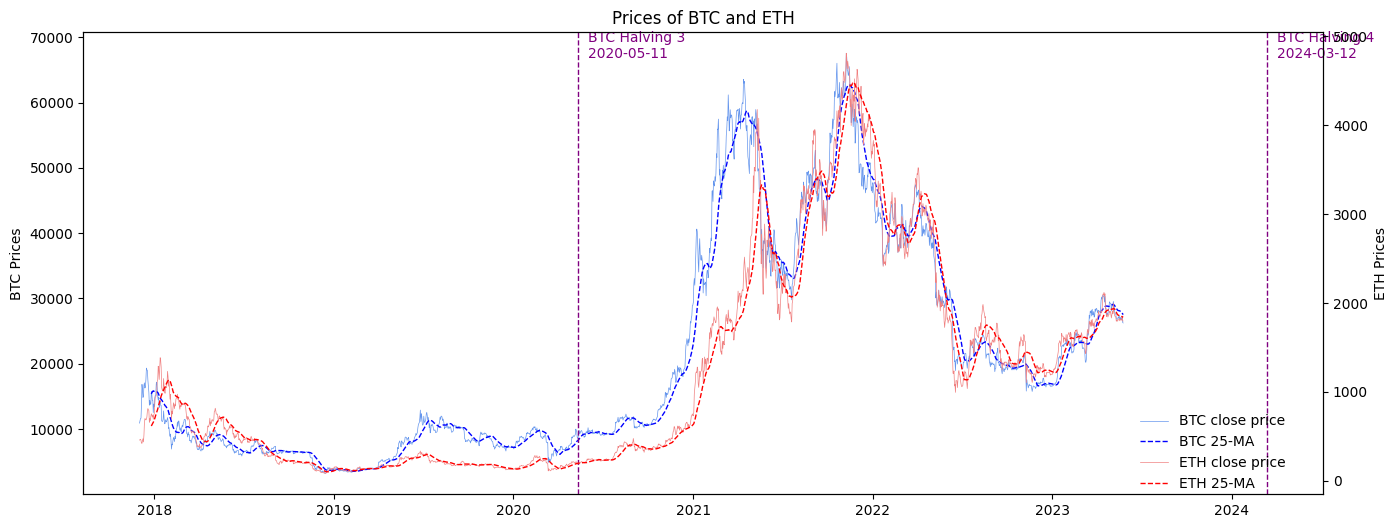

In [17]:
rolling_window = 25
btc_price_df['close_avg'] = btc_price_df['close'].rolling(window=rolling_window).mean()
eth_price_df['close_avg'] = eth_price_df['close'].rolling(window=rolling_window).mean()

def func_halving_dates(ax, df_x_dates, df_ax1_y):
    halving_dates = ['2009-01-03', '2012-11-28', '2016-07-09', '2020-05-11', '2024-03-12', '2028-06-01'] 
    dates_list = [datetime.strptime(date, '%Y-%m-%d').date() for date in halving_dates]
    

    for i, datex in enumerate(dates_list):
        halving_ts = pd.Timestamp(datex)
        x_max = df_x_dates.max() + timedelta(days=365)
        x_min = df_x_dates.min() - timedelta(days=365)
        if (halving_ts < x_max) and (halving_ts > x_min):
            ax.axvline(x=datex, color = 'purple', linewidth=1, linestyle='dashed')
            ax.text(x=datex  + timedelta(days=20), y=df_ax1_y.max()*0.99, s='BTC Halving ' + str(i) + '\n' + str(datex), color = 'purple')

def func_twinx_legend(ax1, ax2, x_anchor=1.18, y_anchor=1.0):
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc=1, facecolor='white', framealpha=0, bbox_to_anchor=(x_anchor, y_anchor))
    ax2.get_legend().remove()



fig, ax1 = plt.subplots(figsize=(16, 6))
sns.lineplot(data=btc_price_df, x='date', y='close', color='cornflowerblue', linewidth=0.5, label=f'{btc} close price', ax=ax1)
sns.lineplot(data=btc_price_df, x='date', y='close_avg', color='blue', linestyle='dashed', linewidth=1.0, 
    label=f'{btc} {rolling_window}-MA', ax=ax1)
ax1.set_ylabel(f'{btc} Prices')
ax1.set(xlabel=None)
ax2 = ax1.twinx()
sns.lineplot(data=eth_price_df, x='date', y='close', color='lightcoral', linewidth=0.5, label=f'{eth} close price', ax=ax2)
sns.lineplot(data=eth_price_df, x='date', y='close_avg', color='red', linestyle='dashed', linewidth=1.0, label=f'{eth} {rolling_window}-MA', ax=ax2)
ax2.set_ylabel(f'{eth} Prices')
func_twinx_legend(ax1, ax2, 0.98, 0.2)
func_halving_dates(ax1, btc_price_df.date, btc_price_df.close)
#ax1.set_yscale('log'), ax2.set_yscale('log')
plt.title(f'Prices of {btc} and {eth}')
plt.show()

In [18]:
def onchain_data(df):
    df['date'] = pd.to_datetime(df['time'], unit='s')
    df.drop(columns='time', inplace=True)
    df = df[df['hashrate'] > 0.0]
    return df

onchain_info_btc_df = onchain_data(onchain_btc_df)
onchain_info_eth_df = onchain_data(onchain_eth_df)

onchain_info_btc_df.head(3)


,id,symbol,zero_balance_addresses_all_time,unique_addresses_all_time,new_addresses,active_addresses,transaction_count,transaction_count_all_time,large_transaction_count,average_transaction_value,block_height,hashrate,difficulty,block_time,block_size,current_supply,date
0,1182,BTC,315512049,339109926,488452,965635,326354,277392487,31381,6.565847,497275,1.080032e+07,1.347001e+12,535.662500,1036298,1.671594e+07,2017-12-02
1,1182,BTC,315974898,339649758,539832,1032301,353044,277745531,23273,5.298105,497451,1.177726e+07,1.347001e+12,491.228571,1047375,1.671814e+07,2017-12-03
2,1182,BTC,316486668,340271118,621360,1154127,400686,278146217,40778,6.522200,497632,1.207401e+07,1.347001e+12,479.155556,1068300,1.672040e+07,2017-12-04


In [19]:

def prepare_balancedistribution(df):
  df['balance_distribution'] = df['balance_distribution'].apply(lambda x: [i for i in x])
  json_struct = json.loads(df[['time','balance_distribution']].to_json(orient="records"))    
  df_ = pd.json_normalize(json_struct)
  df_['date'] = pd.to_datetime(df_['time'], unit='s')
  df_flat = pd.concat([df_.explode('balance_distribution').drop(['balance_distribution'], axis=1),
           df_.explode('balance_distribution')['balance_distribution'].apply(pd.Series)], axis=1)
  df_flat.reset_index(drop=True, inplace=True)
  df_flat['range'] = ['' + str(float(df_flat['from'][x])) + '_to_' + str(float(df_flat['to'][x])) for x in range(df_flat.shape[0])]
  df_flat.drop(columns=['from','to', 'time'], inplace=True)


  df_flat = df_flat[~df_flat['range'].isin(['100000.0_to_0.0'])]
  df_flat['range'].iloc[df_flat['range'] == '1e-08_to_0.001'] = '0.0_to_0.001'
  return df_flat

# Load the balance distribution data for Bitcoin
base_url = 'https://min-api.cryptocompare.com/data/blockchain/balancedistribution/histo/day?fsym='
df_raw = api_request(f'{base_url}{btc}&limit={data_limit}')
df_distr = prepare_balancedistribution(df_raw)
df_distr.head(3)

,date,totalVolume,addressesCount,range
0,2017-12-02,2367.251107,13337046.0,0.0_to_0.001
1,2017-12-02,17802.871323,4399165.0,0.001_to_0.01
2,2017-12-02,113116.819413,3596997.0,0.01_to_0.1


## Correlation between BTC and ETH 

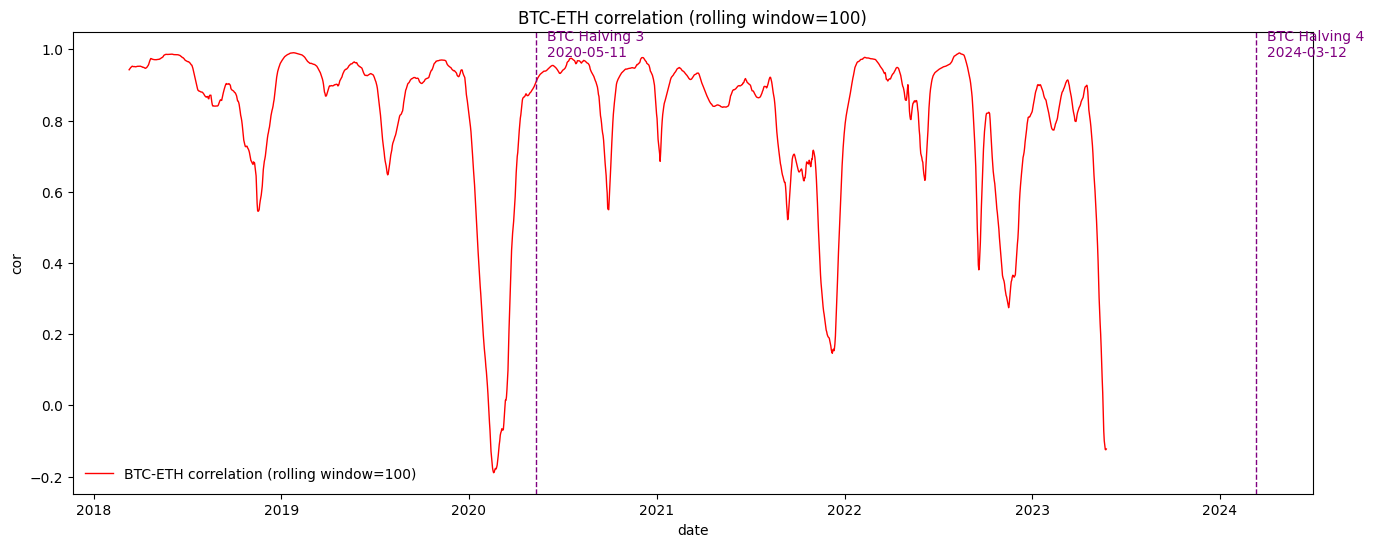

In [20]:
rolling_window = 100
df_price_merged = pd.DataFrame.from_dict(data={f'close_{eth}': eth_price_df['close'], f'close_{btc}': btc_price_df['close'], 'date': btc_price_df['date']})

df_temp = pd.DataFrame({'cor': eth_price_df.close.rolling(rolling_window).corr(btc_price_df.close).dropna()})

df_cor_dateindex = df_price_merged.join(df_temp[::-1].set_index(df_temp.index)).dropna().set_index('date')

fig, ax1 = plt.subplots(figsize=(16, 6))
label = f'{btc}-{eth} correlation (rolling window={rolling_window})'
sns.lineplot(data=df_cor_dateindex, x=df_cor_dateindex.index, y='cor', color='red', linewidth=1.0, label=label)
func_halving_dates(ax1, df_cor_dateindex.index, df_cor_dateindex[f'cor'])
plt.legend(framealpha=0);
plt.title(label);


## Distribution of Total Address Count for each coin by Holder Amount

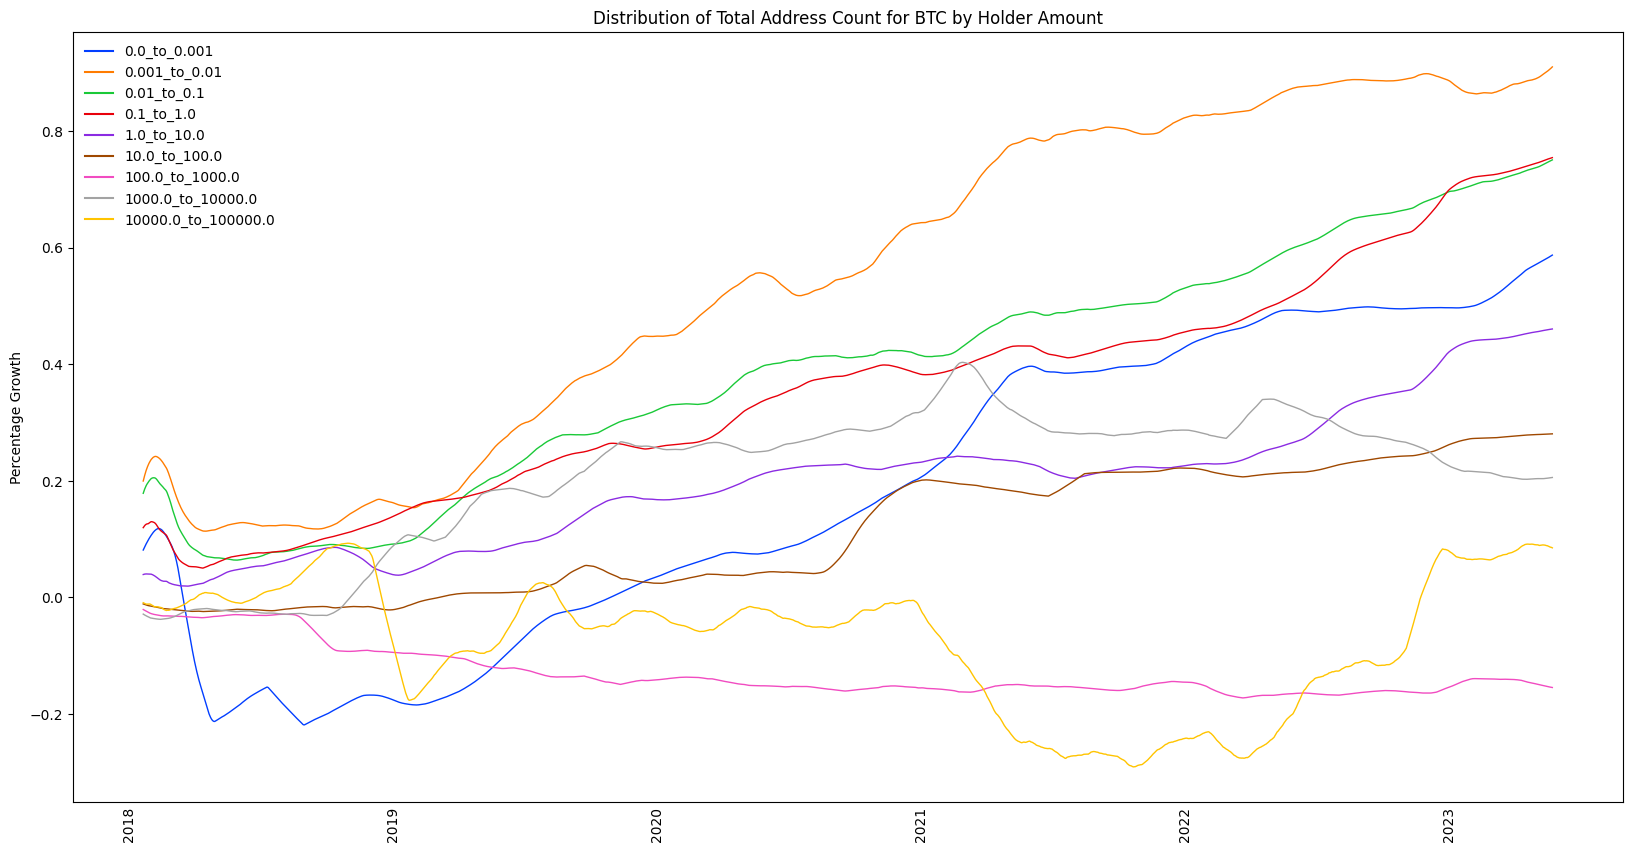

In [21]:
distribution_df = df_distr.copy()

for i in list(distribution_df.range.unique()):
    distribution_df.loc[df_distr.range == i, 'addressesCount_pct_cum'] = distribution_df[distribution_df.range == i]['addressesCount'].pct_change().dropna().cumsum().rolling(window=50).mean()
distribution_df.dropna(inplace=True)

fig, ax1 = plt.subplots(figsize=(20, 10))
sns.lineplot(data=distribution_df, x='date', hue='range', linewidth = 1.0, y='addressesCount_pct_cum', ax=ax1, palette='bright')
plt.ylabel('Percentage Growth')
ax1.tick_params(axis="x", rotation=90, labelsize=10, length=0)
ax1.set(xlabel=None)
plt.title(f'Distribution of Total Address Count for {btc} by Holder Amount')
plt.legend(framealpha=0)
plt.show()



## Network Hashrate and Difficulty

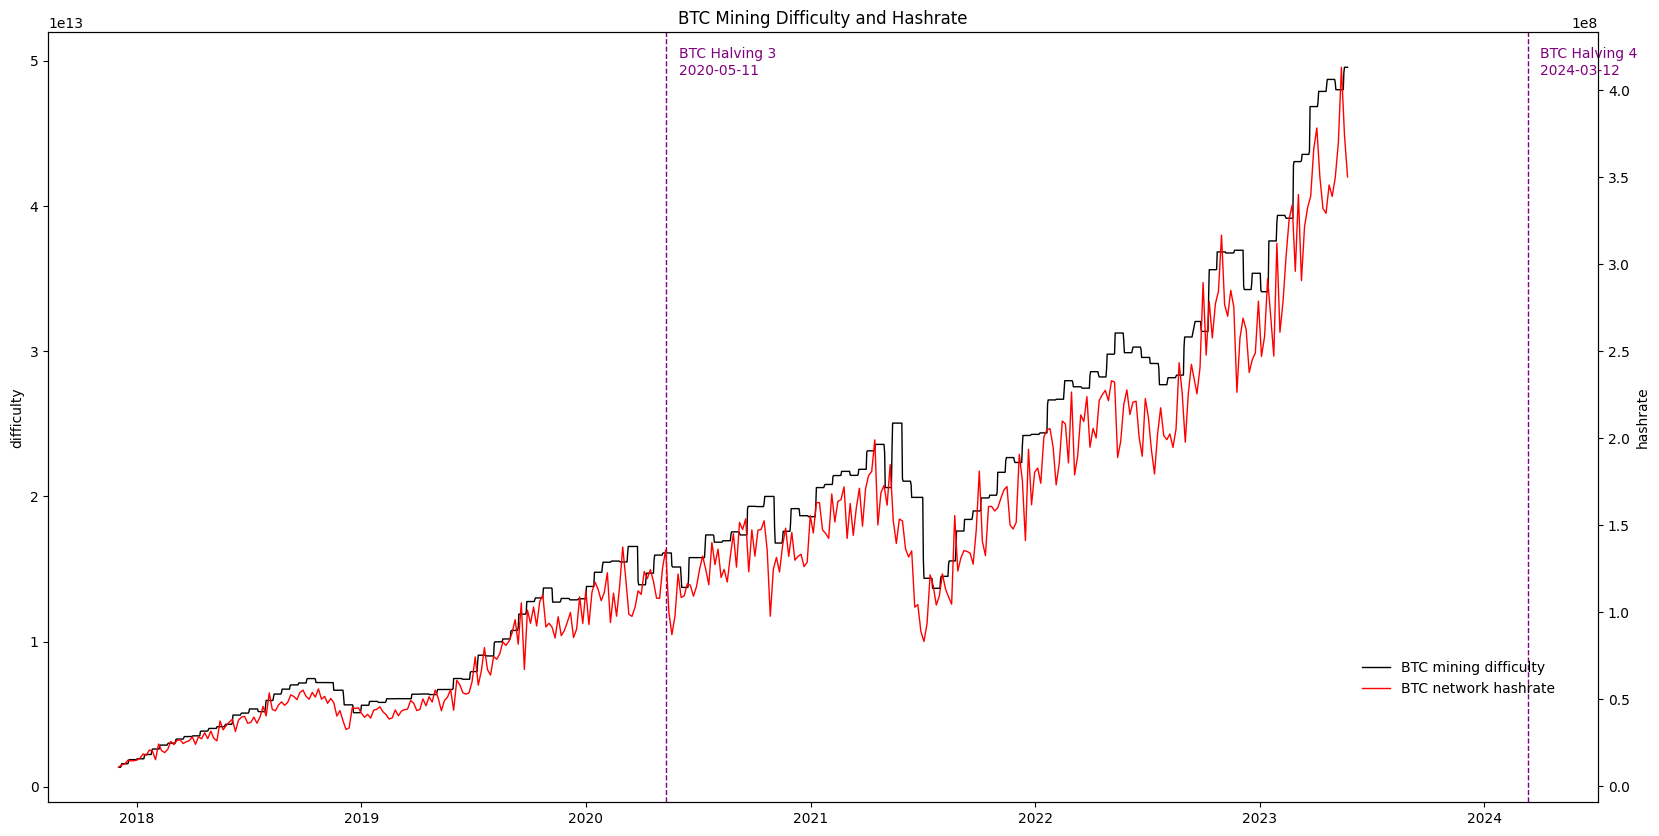

In [22]:
fig, ax1 = plt.subplots(figsize=(20, 10))

sns.lineplot(data=onchain_info_btc_df, x='date', y='difficulty', linewidth=1.0, color='black', ax=ax1, label=f'{btc} mining difficulty')


ax2=ax1.twinx()

sns.lineplot(data=onchain_info_btc_df[::5], x='date', y='hashrate', linewidth=1.0, color='red', ax=ax2, label =f'{btc} network hashrate')
func_twinx_legend(ax1, ax2, 0.98, 0.2)
func_halving_dates(ax1, onchain_info_btc_df.date, onchain_info_btc_df.difficulty)

ax1.set(xlabel=None)
plt.title(f'{btc} Mining Difficulty and Hashrate');
plt.show();




## Coin price and Difficulty

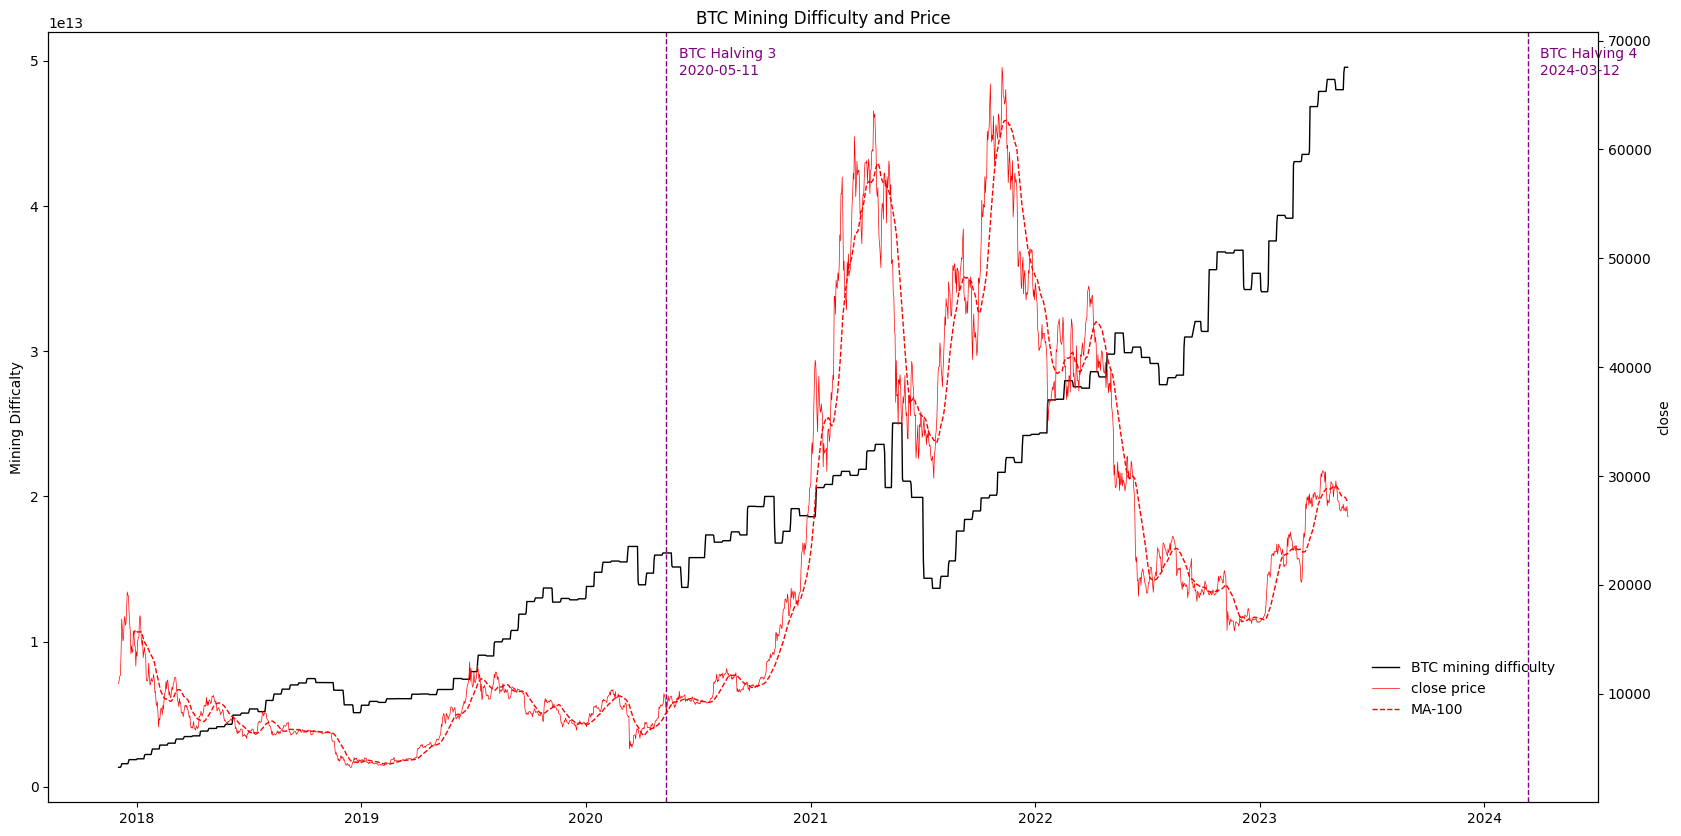

In [23]:
rolling_window = 25

btc_price_df['close_avg'] = btc_price_df['close'].rolling(window=rolling_window).mean()

fig, ax1 = plt.subplots(figsize=(20, 10))

sns.lineplot(data=onchain_info_btc_df, x='date', y='difficulty', linewidth=1.0, color='black', ax=ax1, label=f'{btc} mining difficulty')
ax2=ax1.twinx()
sns.lineplot(data=btc_price_df, x='date', y='close', linewidth=0.5, color='red', ax=ax2, label=f'close price')
sns.lineplot(data=btc_price_df, x='date', y='close_avg', linewidth=1.0, linestyle='--', color='red', ax=ax2, label=f'MA-100')

func_twinx_legend(ax1, ax2, 0.98, 0.2)
func_halving_dates(ax1, onchain_info_btc_df.date, onchain_info_btc_df.difficulty)

ax1.set(xlabel=None)
ax1.set(ylabel='Mining Difficalty')
plt.title(f'{btc} Mining Difficulty and Price');
plt.show();

## Active Addresses compared to bitcoin

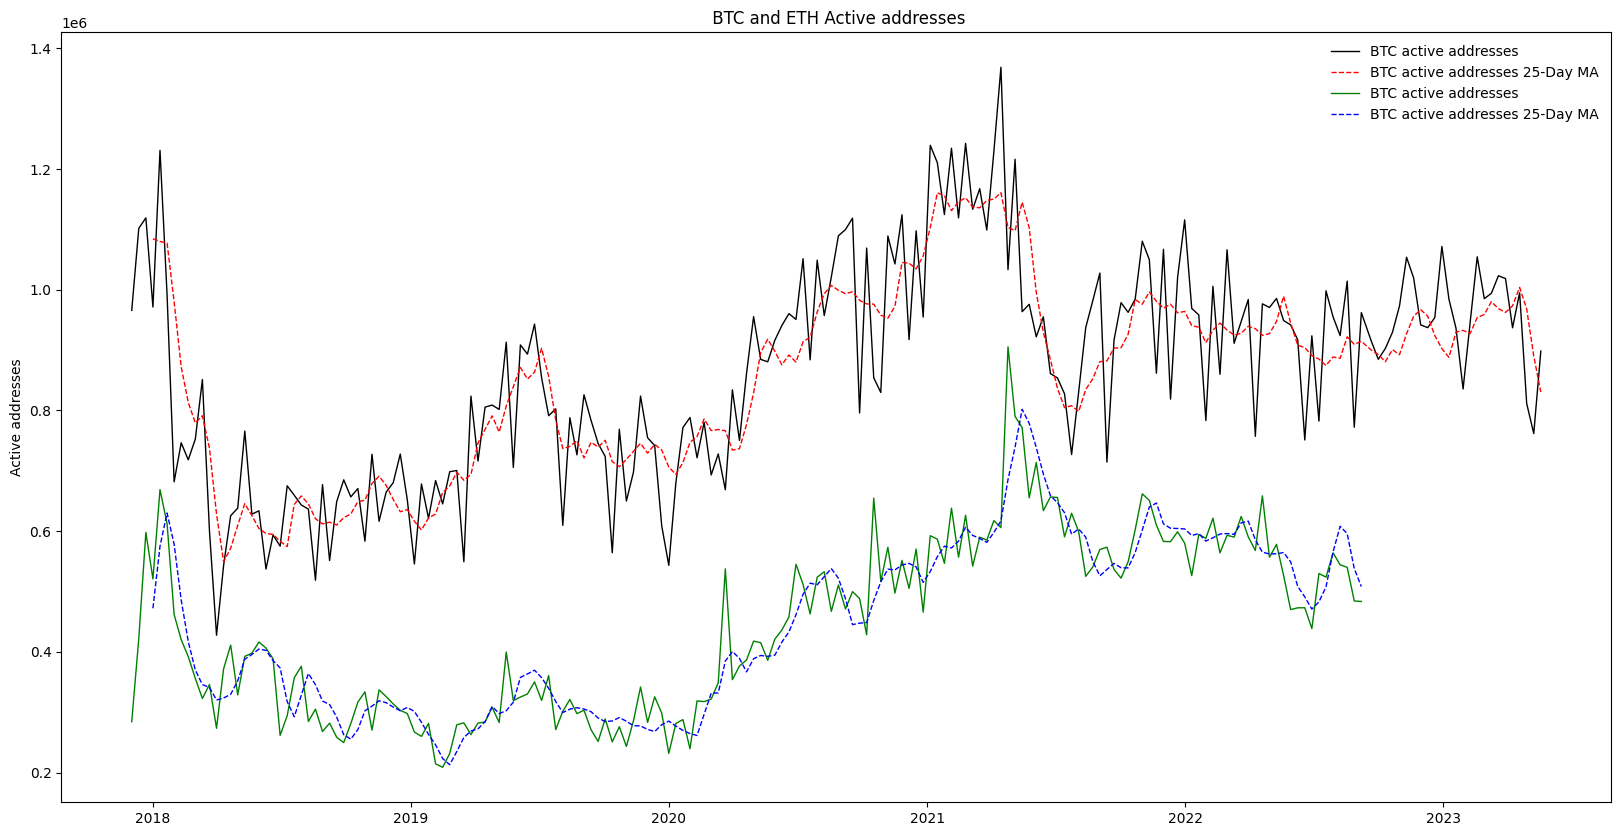

In [24]:
fig, ax1 = plt.subplots(figsize=(20, 10))

rolling_window = 25

active_addresses_ma_btc = onchain_info_btc_df['active_addresses'].rolling(window=rolling_window).mean()
sns.lineplot(data=onchain_info_btc_df[-1*data_limit::10], x='date', y='active_addresses', linewidth=1.0, color='black', ax=ax1, label=f'{btc} active addresses')
sns.lineplot(data=onchain_info_btc_df[-1*data_limit::10], x='date', y=active_addresses_ma_btc, linewidth=1.0, color='red', linestyle='--', ax=ax1, label=f'{btc} active addresses {rolling_window}-Day MA')

active_addresses_ma_eth = onchain_info_eth_df['active_addresses'].rolling(window=rolling_window).mean()
sns.lineplot(data=onchain_info_eth_df[-1*data_limit::10], x='date', y='active_addresses', linewidth=1.0, color='green', ax=ax1, label=f'{btc} active addresses')
sns.lineplot(data=onchain_info_eth_df[-1*data_limit::10], x='date', y=active_addresses_ma_eth, linewidth=1.0, color='blue', linestyle='--', ax=ax1, label=f'{btc} active addresses {rolling_window}-Day MA')

ax1.set(xlabel=None)
ax1.set(ylabel='Active addresses')
plt.title(f' {btc} and {eth} Active addresses')
plt.legend(framealpha=0)
plt.show()

## Transaction Count compared to Bitcoin 

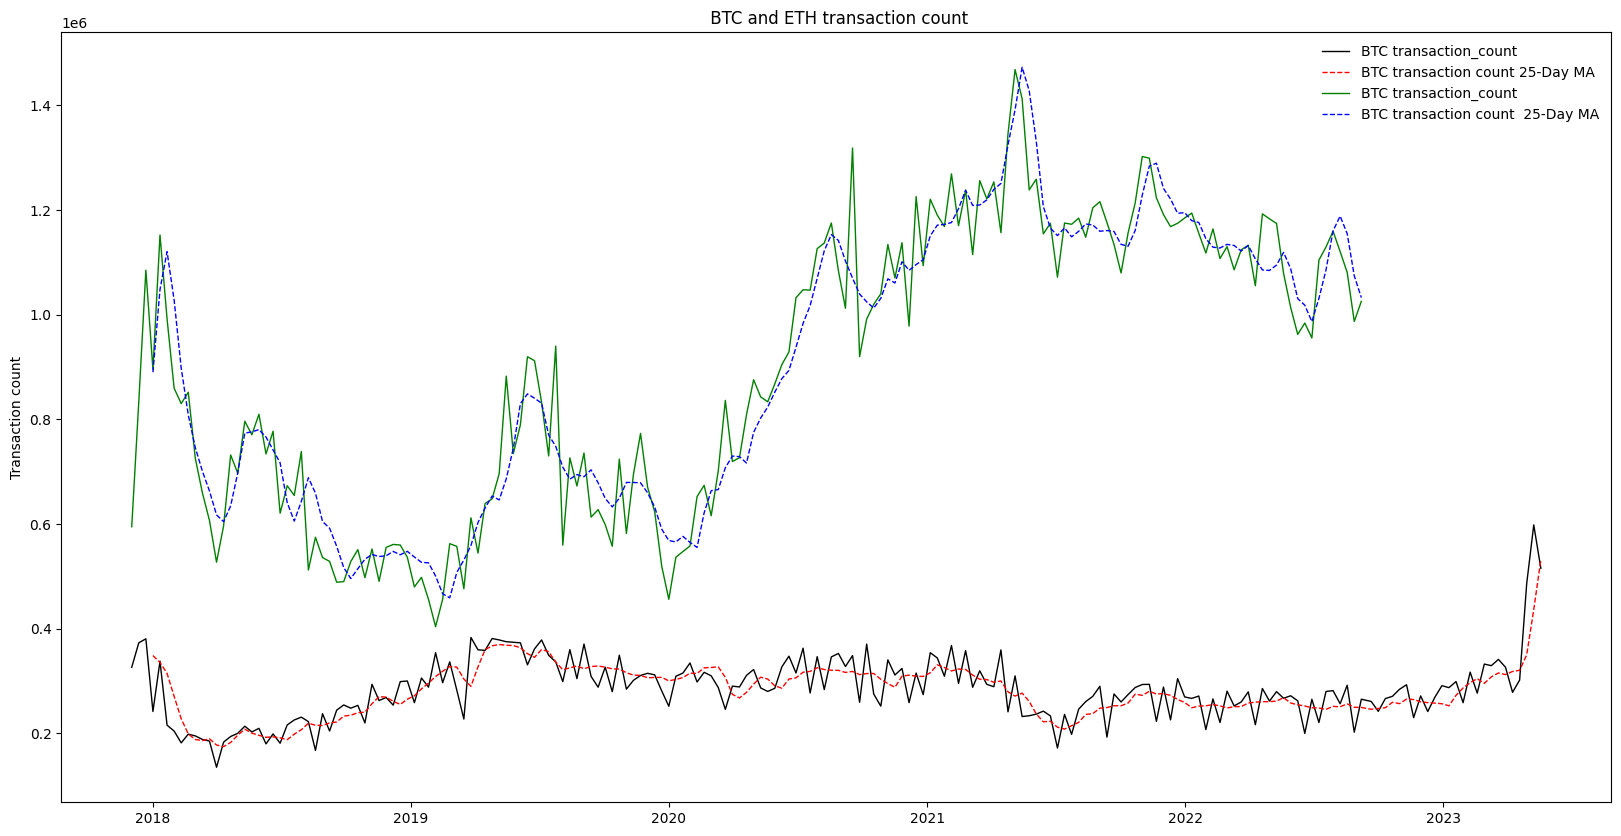

In [25]:
fig, ax1 = plt.subplots(figsize=(20, 10))

rolling_window = 25

transaction_count_ma_btc = onchain_info_btc_df['transaction_count'].rolling(window=rolling_window).mean()
sns.lineplot(data=onchain_info_btc_df[-1*data_limit::10], x='date', y='transaction_count', linewidth=1.0, color='black', ax=ax1, label=f'{btc} transaction_count')
sns.lineplot(data=onchain_info_btc_df[-1*data_limit::10], x='date', y=transaction_count_ma_btc, linewidth=1.0, color='red', linestyle='--', ax=ax1, label=f'{btc} transaction count {rolling_window}-Day MA')

transaction_count_ma_eth = onchain_info_eth_df['transaction_count'].rolling(window=rolling_window).mean()
sns.lineplot(data=onchain_info_eth_df[-1*data_limit::10], x='date', y='transaction_count', linewidth=1.0, color='green', ax=ax1, label=f'{btc} transaction_count')
sns.lineplot(data=onchain_info_eth_df[-1*data_limit::10], x='date', y=transaction_count_ma_eth, linewidth=1.0, color='blue', linestyle='--', ax=ax1, label=f'{btc} transaction count  {rolling_window}-Day MA')

ax1.set(xlabel=None)
ax1.set(ylabel='Transaction count')
plt.title(f' {btc} and {eth} transaction count')
plt.legend(framealpha=0)
plt.show()


## Large Transactions ETH vs BTC

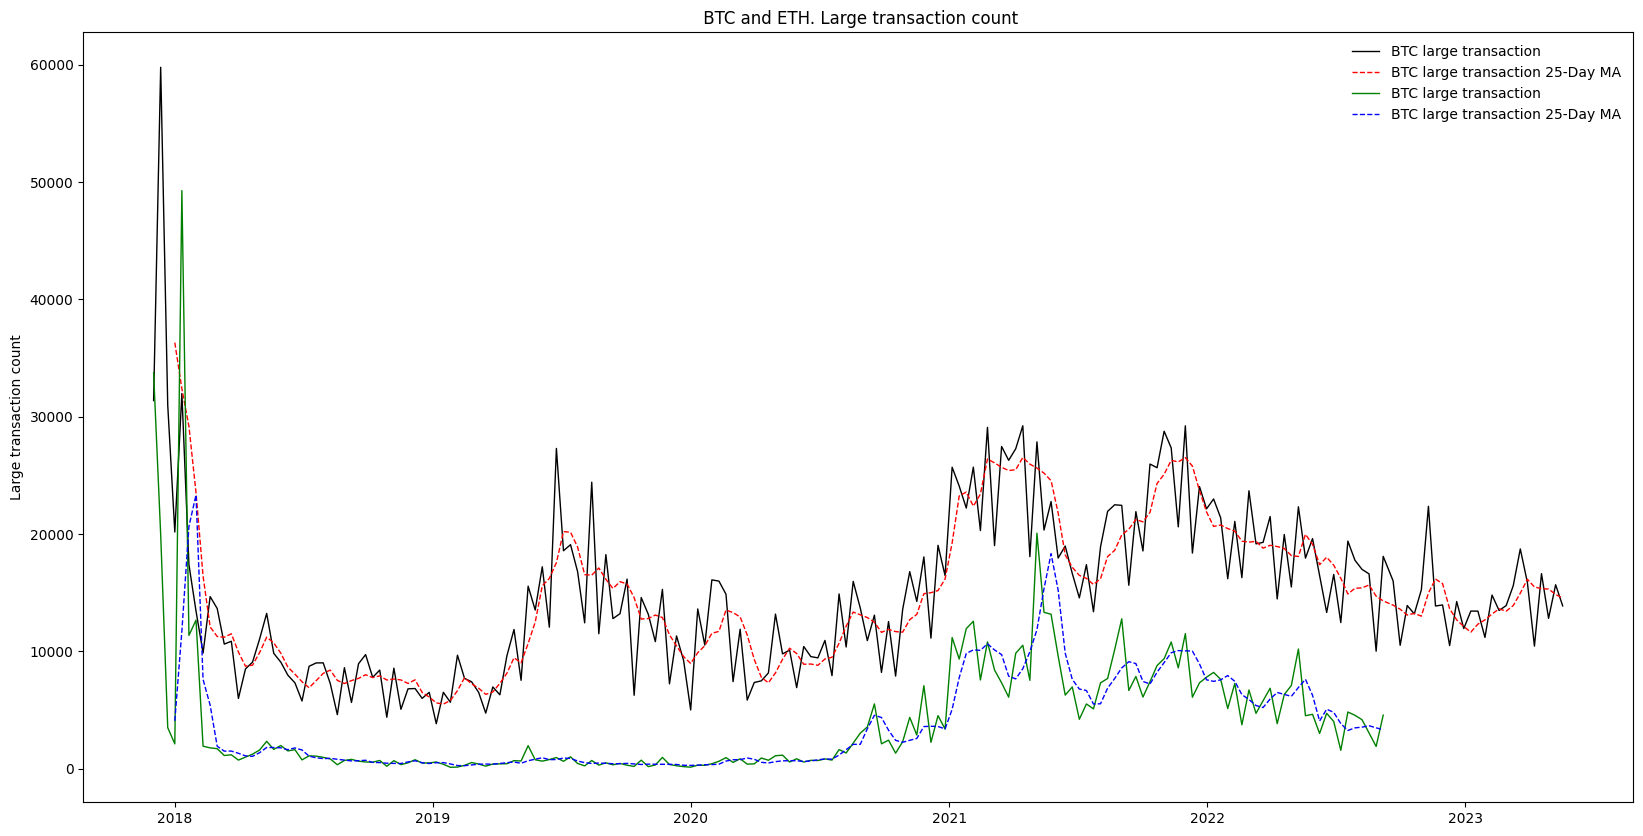

In [26]:

fig, ax1 = plt.subplots(figsize=(20, 10))

rolling_window = 25

large_transaction_count_ma_btc = onchain_info_btc_df['large_transaction_count'].rolling(window=rolling_window).mean()
sns.lineplot(data=onchain_info_btc_df[-1*data_limit::10], x='date', y='large_transaction_count', linewidth=1.0, color='black', ax=ax1, label=f'{btc} large transaction')
sns.lineplot(data=onchain_info_btc_df[-1*data_limit::10], x='date', y=large_transaction_count_ma_btc, linewidth=1.0, color='red', linestyle='--', ax=ax1, label=f'{btc} large transaction {rolling_window}-Day MA')

large_transaction_count_ma_eth = onchain_info_eth_df['large_transaction_count'].rolling(window=rolling_window).mean()
sns.lineplot(data=onchain_info_eth_df[-1*data_limit::10], x='date', y='large_transaction_count', linewidth=1.0, color='green', ax=ax1, label=f'{btc} large transaction')
sns.lineplot(data=onchain_info_eth_df[-1*data_limit::10], x='date', y=large_transaction_count_ma_eth, linewidth=1.0, color='blue', linestyle='--', ax=ax1, label=f'{btc} large transaction {rolling_window}-Day MA')

ax1.set(xlabel=None)
ax1.set(ylabel='Large transaction count')
plt.title(f' {btc} and {eth}. Large transaction count')
plt.legend(framealpha=0)
plt.show()




